<div style="text-align: right"> 24 April, 2017 </div>

# Exercise 2

### by Anne Peter (anne.peter@uni-weimar.de)
---

# Implementing the Travelling Salesman Problem

## 1. Travelling Salesman Problem

Given a list of cities and the distances between each pair of cities, what is the shortest possible route that visits each city exactly once and returns to the origin city?

The TSP is an **NP-Hard Problem**. That does not necessarily mean any one instance of the problem will be hard to solve, it just means that we do not currently have an algorithm that can give us the guaranteed best solution for all problems in “polynomial time”. We can’t make predictions about how long it might take to find the best solution to the TSP from just looking at the data. We have no way of knowing how long a problem that is twice as large as one that took 2 minutes to solve will take.

Although we might not be able to make predications about finding the best solution, we often only want a _good solution_ to the TSP. We aren’t always so worried if we find a route amongst 1000 cities that is only a few miles longer than the best solution – particularly if it would take an inordinate amount of computing time to get from the good solution we already have to the best solution.

<img src="https://upload.wikimedia.org/wikipedia/commons/c/c4/TSP_Deutschland_3.png" />

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/30/Weighted_K4.svg/220px-Weighted_K4.svg.png" align="left">
<br>
<br>
        TSP can be modelled as an undirected weighted graph:
        - cities are the graph's vertices
        - paths are the graph's edges
        - a path's distance is the edge's weight

**Adjacency matrix** for the graph above:

- undirected graphs are always symetric

|        | A     | B     | C     | D     |
| :----: | :---: | :---: | :---: | :---: |
| **A**  |  0    | 20    | 42    | 35    |
| **B**  | 20    | 0     | 30    | 34    |
| **C**  | 42    | 30    | 0     | 12    |
| **D**  | 35    | 34    | 12    | 0     |

## 1.1 TSP in Python

In [2]:
from itertools import permutations


def distance(point1, point2):
    """
    Returns the Euclidean distance of two points in the Cartesian Plane.

    >>> distance([3,4],[0,0])
    5.0
    
    """
    return ((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2) ** 0.5

The Euclidean distance between P1 = (x1, y1) and P2 = (x2, y2) is:

$d_{P_{1},P_{2}} = \sqrt{(x_{1} - x_{2})^2 + (y_{1} - y_{2})^2}$

In [3]:
print(distance([3,6],[7,6]) + distance([7,6],[12,6]))

9.0


In [4]:
def total_distance(points):
    """
    Returns the length of the path passing throught
    all the points in the given order.

    >>> total_distance([[1,2],[4,6]])
    5.0
    >>> total_distance([[3,6],[7,6],[12,6]])
    9.0
    """
    return sum([distance(point, points[index + 1]) for index, point in enumerate(points[:-1])])

- [:-1] means "all elements of the sequence but the last"
- _enumerate_ enumerates all elements of the given sequence (here: points), start is 0

In [5]:
# example for enumerate
seasons = ['Spring', 'Summer', 'Fall', 'Winter']
list(enumerate(seasons))

[(0, 'Spring'), (1, 'Summer'), (2, 'Fall'), (3, 'Winter')]

- the for loop goes over every _index_ of the new enumarated sequence and every _point_ of the sequence
- the method _distance_ computes the distance between each point and its successor, added together by _sum_

In [6]:
def travelling_salesman(points, start = None):
    """
    Finds the shortest route to visit all the cities by bruteforce.
    Time complexity is O(N!), so never use on long lists.

    >>> travelling_salesman([[0,0],[10,0],[6,0]])
    ([0, 0], [6, 0], [10, 0])
    >>> travelling_salesman([[0,0],[6,0],[2,3],[3,7],[0.5,9],[3,5],[9,1]])
    ([0, 0], [6, 0], [9, 1], [2, 3], [3, 5], [3, 7], [0.5, 9])
    """
    if start is None:
        start = points[0]
    return min([perm for perm in permutations(points) if perm[0] == start], key = total_distance)

- _permutations_ returns tuples with all possible orderings of _points_ and no repeated elements
- returns the minimum of all possible tuples by the help of *total\_distance*

In [7]:
def main():
    points = [[0, 0], [1, 5.7], [2, 3], [3, 7],
              [0.5, 9], [3, 5], [9, 1], [10, 5]]
    result = travelling_salesman(points)
    distance_result = total_distance(result)
    print("""The minimum distance to visit all the following points: {}
        starting at {} is {} and takes this route: {}.""".format(
        points,
        points[0],
        distance_result,
        result,))


if __name__ == "__main__":
    main()

The minimum distance to visit all the following points: [[0, 0], [1, 5.7], [2, 3], [3, 7], [0.5, 9], [3, 5], [9, 1], [10, 5]]
        starting at [0, 0] is 25.90302275027582 and takes this route: ([0, 0], [2, 3], [3, 5], [1, 5.7], [0.5, 9], [3, 7], [10, 5], [9, 1]).


## 1.2 Solving TSP using Hill Climbing

### Recap: Hill Climbing

<img src="https://i.warosu.org/data/sci/img/0070/17/1421569605807.jpg" align="left">

Idea:
- use only your local solution and evaluate your 
neighbors to find a better one
- repeat this step until no better neighbor exists

Pros:
- requires few resources (current state and neighbors)
- finds local optimum (global is possible)
- useful if the search space is huge (even unlimited)

Cons:

- is prone to get stuck at the top of local maximum and on plateaus
- strongly depends on “good” initialization

### Hill Climbing Algorithm

We will use the standard Python lists to represent a route/tour through a collection of cities. Each city will simply be assigned a number from 0 to N-1 (where N is the number of cities) and therefore our list of cities will be a list of unique numbers between 0 and N-1.

#### Adjacency Matrix 

We also need to specify a “distance matrix” that we can use to find out the distance between two cities. To generate a distance matrix for a set of x,y coordinates the following will do nicely:

In [8]:
def cartesian_matrix(coords):
    '''
    Creates a distance matrix for the city coords using straight line distances
    computed by the Euclidean distance of two points in the Cartesian Plane.
    '''
    matrix = {}
    for i,(x1,y1) in enumerate(coords):
        for j,(x2,y2) in enumerate(coords):
            dx,dy = x1-x2,y1-y2
            dist = (dx*dx + dy*dy) ** 0.5
            matrix[i,j] = dist
    return matrix

- cartesian_matrix() takes a Python list of (x,y) tuples and outputs a Python dictionary that contains the distance between the distances between any two cities:

In [9]:
test_matrix = cartesian_matrix([(0,0),(1,0),(1,1)])

print(test_matrix)
print()
print(test_matrix[1,2])

{(0, 0): 0.0, (0, 1): 1.0, (0, 2): 1.4142135623730951, (1, 0): 1.0, (1, 1): 0.0, (1, 2): 1.0, (2, 0): 1.4142135623730951, (2, 1): 1.0, (2, 2): 0.0}

1.0


Where matrix[1,2] gives the distance between city number 1 and city number 2. In our case this is the same as matrix[2,1], but for some TSP’s it may not be (for example if there is a one way street between cities that means we have to take an indirect route).

#### Read City Coodinates from File

In addition to generating the distance matrix we will probably also want to read the city coordinates from a text file (one x,y per line):

In [36]:
def read_coords(coord_file):
    coords=[]
    for line in coord_file:
        x,y = line.strip().split(',')
        coords.append((float(x),float(y)))
    return coords


coord_file = open('city100.txt', 'r') 
coords = read_coords(coord_file)

matrix = cartesian_matrix(coords)

That should be sufficient for generating distance matrices for now. On real world problems generating a distance matrix may be more complicated – you might need to take map data and calculate what the actual distance by road between any two cities is.
This process can be done offline, before we start optimising our routes and is a subject for another time.

Ok, so now we can read in a list of cities from a file and generate our distance matrix. What next? Well it would be good if we knew how long a route was:

#### Compute Total Distance

In [11]:
#  matrix is a distance matrix and tour is a list of cities (as integers)
def tour_length(matrix, tour):
    '''Sum up the total length of the tour based on the distance matrix'''
    total = 0
    num_cities = len(list(tour))
    for i in list(range(num_cities)):
        j = (i+1) % num_cities
        city_i = tour[i]
        city_j = tour[j]
        total += matrix[city_i, city_j]
    return total

#### Implementing the Tweak Operators

We are going to implement the two tweak operators as generator functions, that will return (in a random order) all of the possible versions of a route that can be made in one step of the operator.<br>
Generators are iterators, but you can only iterate over them once. It's because they do not store all the values in memory, they generate the values on the fly.<br>
By using a generator function we can assess each different possibility and perhaps decide to not generate any more variations – which saves us the overhead of generating all of the combinations in one go.

Both tweak operators rely on the following generator function:

In [12]:
import random

def all_pairs(size, shuffle = random.shuffle):
    r1 = list(range(size))
    r2 = list(range(size))
    if shuffle:
        shuffle(r1)
        shuffle(r2)
    for i in r1:
        for j in r2:
            yield (i,j)

Which will generate all pairings of the numbers from 0 to size as (i,j) tuples in a random order (needs the random module to work).

So each tweak operator then looks like:

In [38]:
from copy import deepcopy

def swapped_cities(tour):
    '''Generator to create all possible variations where two cities have been swapped.'''
    for i,j in all_pairs(len(tour)):
        if i < j:
            copy = deepcopy(tour)
            copy[i],copy[j] = tour[j],tour[i]
            yield copy

def reversed_sections(tour):
    '''
    Generator to return all possible variations where the section between two cities are swapped.
    It preserves entire sections of a route, yet still affects the ordering of multiple cities in one go.
    '''
    for i,j in all_pairs(len(tour)):
        if i != j:
            copy = deepcopy(tour)
            if i < j:
                copy[i:j+1] = reversed(tour[i:j+1])
            else:
                copy[i+1:] = reversed(tour[:j])
                copy[:j] = reversed(tour[i+1:])
            if copy != tour: # no point returning the same tour
                yield copy

# usage
for tour in swapped_cities([1,2,3]):
    print(tour)

print()
    
for tour in reversed_sections([1,2,3]):
    print(tour)

[2, 1, 3]
[3, 2, 1]
[1, 3, 2]

[3, 2, 1]
[2, 1, 3]
[2, 3, 1]
[3, 1, 2]
[1, 3, 2]


#### Getting Started

To begin with the hill-climbing code we need two functions:

- an initialisation function – that will return a random solution
- an objective function – that will tell us how “good” a solution is

For the TSP the initialisation function will just return a tour of the correct length that has the cities arranged in a random order.

The objective function will return the negated length of a tour/solution. We do this because we want to maximise the objective function, while at the same time minimise the tour length.

As the hill-climbing code won’t know specifically about the TSP we need to ensure that the initialisation function takes no arguments and returns a tour of the correct length and the objective function takes one argument (the solution tour) and returns the negated length.

So assuming we have our city coordinates in a variable _coords_ and our distance matrix in _matrix_ we can define the objective function and initialisation functions using the function *init\_random\_tour*:

In [14]:
def init_random_tour(tour_length):
   tour = list(range(tour_length))
   random.shuffle(list(tour))
   return tour

init_function = lambda: init_random_tour(len(coords))
objective_function = lambda tour: -tour_length(matrix, tour) # note the negation

#### Short Explanation of Lambda Functions

- creation of anonymous functions

In [15]:
# normal function definition
def f(x): return x**2

# lambda funtion definition
g = lambda x: x**2

print(f(5))
print(g(5))

25
25


- lambda definition does not include a "return" statement
- it always contains an expression which is returned
- you can put a lambda definition anywhere a function is expected
- you don't have to assign it to a variable

#### Basic Hill-Climb

In [16]:
def hillclimb(init_function, move_operator, objective_function, max_evaluations):
    '''Hillclimb until either max_evaluations is reached or we are at a local optima.'''
    best = init_function()
    best_score = objective_function(best)
    
    num_evaluations = 1
    
    while num_evaluations < max_evaluations:
        # examine moves around our current position
        move_made = False
        for next in move_operator(best):
            if num_evaluations >= max_evaluations:
                break
            
            next_score = objective_function(next)
            num_evaluations += 1
            # see if this move is better than the current
            if next_score > best_score:
                best = next
                best_score = next_score
                move_made = True
                break # depth first search
            
        if not move_made:
            break # we couldn't find a better move (must be at a local maximum)
    
    return (num_evaluations,best_score,best)

In [17]:
from PIL import Image, ImageDraw, ImageFont

def write_tour_to_img(coords, tour, title, img_file):
    padding = 20
    # shift all coords in a bit
    coords = [(x+padding,y+padding) for (x,y) in coords]
    maxx, maxy = 0,0
    for x,y in coords:
        maxx = max(x,maxx)
        maxy = max(y,maxy)
    maxx += padding
    maxy += padding
    img = Image.new("RGB",(int(maxx), int(maxy)), color=(255,255,255))
    
    font=ImageFont.load_default()
    d=ImageDraw.Draw(img);
    num_cities = len(tour)
    for i in range(num_cities):
        j = (i+1) % num_cities
        city_i = tour[i]
        city_j = tour[j]
        x1,y1 = coords[city_i]
        x2,y2 = coords[city_j]
        d.line((int(x1), int(y1), int(x2), int(y2)), fill=(0,0,0))
        d.text((int(x1)+7, int(y1)-5), str(i), font=font, fill=(32,32,32))
    
    
    for x,y in coords:
        x,y = int(x), int(y)
        d.ellipse((x-5, y-5, x+5, y+5), outline=(0,0,0), fill=(196,196,196))
    
    d.text((1,1), title, font=font, fill=(0,0,0))
    
    del d
    img.save(img_file, "PNG")

In [18]:
# move_operator = swapped_cities
move_operator = reversed_sections # better

max_evaluations = 500

num_evaluations, best_score, best = hillclimb(init_function, move_operator, objective_function, max_evaluations)

print(best_score)
print(best)

-16035.517246233385
[71, 98, 86, 30, 68, 44, 0, 81, 17, 29, 82, 70, 85, 77, 21, 20, 5, 66, 69, 99, 9, 14, 34, 78, 43, 87, 2, 1, 41, 96, 16, 54, 94, 47, 39, 31, 8, 57, 89, 92, 28, 25, 75, 52, 49, 64, 63, 80, 11, 12, 32, 61, 18, 22, 67, 23, 10, 56, 59, 74, 62, 90, 3, 97, 15, 26, 51, 48, 65, 4, 83, 36, 24, 27, 91, 46, 50, 35, 73, 60, 37, 6, 7, 33, 79, 88, 38, 19, 84, 45, 76, 58, 72, 42, 40, 93, 95, 55, 53, 13]


In [19]:
filename = "test500.PNG"

write_tour_to_img(coords, best, filename, open(filename, 'ab'))

<img src="test500.PNG">

In [20]:
max_evaluations = 5000

num_evaluations, best_score, best = hillclimb(init_function, move_operator, objective_function, max_evaluations)

print(best_score)
print(best)

-5746.654404651131
[69, 60, 87, 33, 24, 70, 27, 91, 40, 25, 2, 93, 12, 64, 45, 37, 6, 75, 4, 83, 62, 53, 71, 32, 15, 94, 55, 76, 95, 72, 58, 13, 52, 65, 48, 84, 54, 41, 16, 61, 36, 18, 34, 21, 10, 88, 67, 22, 90, 1, 63, 23, 96, 19, 31, 20, 79, 8, 14, 38, 43, 74, 49, 78, 26, 3, 51, 97, 47, 11, 80, 85, 28, 7, 46, 89, 29, 17, 98, 42, 81, 57, 59, 82, 99, 92, 5, 68, 0, 35, 56, 39, 86, 50, 9, 30, 73, 44, 66, 77]


In [21]:
filename = "test5000.PNG"

write_tour_to_img(coords, best, filename, open(filename, 'ab'))

<img src="test5000.PNG">

In [22]:
max_evaluations = 50000

num_evaluations, best_score, best = hillclimb(init_function, move_operator, objective_function, max_evaluations)

print(best_score)
print(best)

-4160.9456573136
[68, 0, 35, 39, 56, 86, 73, 21, 34, 18, 22, 67, 88, 10, 96, 38, 23, 63, 1, 41, 61, 36, 16, 26, 54, 84, 3, 78, 90, 97, 51, 48, 65, 47, 52, 71, 53, 15, 32, 94, 55, 76, 95, 72, 58, 37, 45, 6, 93, 12, 2, 40, 91, 27, 17, 29, 89, 24, 70, 46, 98, 25, 42, 4, 28, 85, 80, 75, 62, 64, 13, 11, 49, 83, 74, 43, 8, 14, 19, 31, 30, 9, 50, 99, 20, 79, 59, 57, 7, 81, 33, 87, 82, 60, 69, 77, 44, 66, 92, 5]


In [23]:
filename = "test50000.PNG"

write_tour_to_img(coords, best, filename, open(filename, 'ab'))

<img src="test50000.PNG">

## 1.3 Solving TSP using Simulated Annealing

As we discussed before, it is possible for an algorithm to find a solution that is “locally optimal”, but not necessarily “globally optimal”. That is to say we may find ourselves with a solution that is the best thing nearby, but it might not be the best thing. This happens with hill-climbing, because when we are offered the choice between two solutions we always take the best solution. The algorithm is greedy and short sighted.

So instead we could try occasionally choosing something that’s worse. By doing that the algorithm can go “downhill” sometimes and hopefully reach new areas of the solution landscape.

### Recap: Simulated Annealing

Simulated annealing is essentially hill-climbing, but with the ability to go downhill (sometimes).

<img src="http://psychicorigami.com/wp-content/uploads/2007/05/bumpy.gif">

It introduces a temperature variable. When the temperature is high a worse solution will have a higher chance of being chosen. It work’s like this:

1. pick an initial solution
2. set an initial temperature
3. choose the next neighbour of the current solution:
    - if the neighbour is better, make that neighbour the current solution
    - if the neighbour is worse, probabilistically make this neighbour the current solution, based on the current
    temperature and how much worse the neighbour is
4. decrease the temperature slightly
5. go to 3.

By slowly cooling the temperature we become less likely to choose worse solutions over time. Initially we are able to make some pretty big jumps around the solution landscape. By the end of a run we’ll be jumping around less and less. In fact if we lower the temperature enough we end up with plain old hill-climbing.

### Simulated Annealing Algorithm

#### Cooling Down

Temperature is a key part of simulated annealing. How we lower the temperature over time is therefore very important. There are a couple of possible approaches, but I’ll show the one outlined by Kirkpatrick et al:

In [24]:
# you should think of a better cooling function
def kirkpatrick_cooling(start_temp, alpha):
    T = start_temp
    while True:
        yield T
        T = alpha * T

The keyword _yield_ is used like return, except the function will return a generator.
Generators are iterators, but you can only iterate over them once. It's because they do not store all the values in memory, they generate the values on the fly

This generator function takes an initial start temperature (start_temp) and returns a series of temperatures that are alpha times the size, where alpha is less than one. So we end up with a temperature that drops off quite quickly and then slowly decreases to practically nothing.

### Probabilistically Choosing a Neighbor

Below is the Python code to decide if what probability we will assign to moving from a solution with a score of prev_score to a solution with a value of next_score at the current temperature.

In [25]:
import math

def P(prev_score, next_score, temperature):
    if next_score > prev_score:
        return 1.0
    elif temperature == 0:
        return 0.0
    else:
        return math.exp(-abs(next_score - prev_score)/temperature)

To keep later logic simpler it's returning 1.0 if next_score is better – so we’ll always choose better solutions.

When the prev_score is worse we create a probability based on the difference between prev_score and next_score scaled by the current temperature. If we chart the probabilities versus the difference in scores we get (with a temperature of 1.0):

<img src="http://psychicorigami.com/wp-content/uploads/2007/06/saprobs.gif">

As can be seen, for small differences (relative to the current temperature) we will have a high probability. This then tails off very quickly, so solutions that are much worse are increasingly less likely to be chosen.

The net-effect being that solutions that are only a little bit worse are still fairly likely to be chosen. Much worse solutions may still be chosen, but it’s much less likely.

#### Remember the Best Solution

One other minor, but key, implementation detail is saving the best solution we find during the annealing process.

During hill-climbing the current solution was always the best solution found, but simulated annealing will deliberately accept worse solutions at times. So we need to make sure we don’t just throw away the best we see. To avoid complicating the algorithm itself with extra checks of scores etc.

I am going to use a class to wrap the objective function. I’ll override the \_\_call\_\_ method of the class, so that I can use the instance of the class like a function – in place of the normal objective function:

In [26]:
class ObjectiveFunction:
    '''
    Class to wrap an objective function and 
    keep track of the best solution evaluated.
    '''
    def __init__(self, objective_function):
        self.objective_function = objective_function
        self.best = None
        self.best_score = None
    
    def __call__(self, solution):
        score = self.objective_function(solution)
        if self.best is None or score > self.best_score:
            self.best_score = score
            self.best = solution
        return score

We can then access then best and best_score fields when we have finished our annealing.

#### Simulated Annealing itself

The code below represents the simulated annealing algorithm. In many respects it is pretty similar to hill-climbing, but we are also concerned with a current temperature and we have introduced a probabilistic element to choosing the next solution.

In [27]:
def anneal(init_function, move_operator, objective_function, max_evaluations, start_temp,alpha):
    
    # wrap the objective function (so we record the best)
    objective_function = ObjectiveFunction(objective_function)
    
    current = init_function()
    current_score = objective_function(current)
    num_evaluations = 1
    
    cooling_schedule = kirkpatrick_cooling(start_temp, alpha)
    
    for temperature in cooling_schedule:
        done = False
        # examine moves around our current position
        for next in move_operator(current):
            if num_evaluations >= max_evaluations:
                done = True
                break
            
            next_score = objective_function(next)
            num_evaluations += 1
            
            # probablistically accept this solution
            # always accepting better solutions
            p = P(current_score, next_score, temperature)
            if random.random() < p:
                current = next
                current_score = next_score
                break
        # see if completely finished
        if done: break
    
    best_score = objective_function.best_score
    best = objective_function.best
    
    return (num_evaluations, best_score, best)

The parameters are much the same as hill-climbing, but there are two extra specific to simulated annealing:

- init_function - the function used to create our initial solution
- move_operator - the function we use to iterate over all possible "moves" for a given solution
- objective_function - used to assign a numerical score to a solution - how "good" the solution is
- max_evaluations - used to limit how much search we will perform (how many times we'll call the objective_function)
- start_temp - the initial starting temperature for annealing
- alpha - should be less than one. controls how quickly the temperature reduces

We are also only reducing the temperature after either accepting a new solution or evaluating all neighbours without choosing any of them. This is done so that temperature will only decrease as we start accepting moves. As that will be less frequent than just evaluating moves we cooling will happen at a slower pace. If we are accepting lots of moves then this will drop the temperature quite quickly. If we are not accepting many moves the temperature will stay steadier - maintaining the likelihood of accepting other "worse" moves. That latter point is useful, as if we are starting to get stuck on a local maximum the temperature won't decrease - hopefully helping us get unstuck.

In [28]:
# move_operator = swapped_cities
move_operator = reversed_sections # better

max_iterations = 500
start_temp = 10
alpha = 0.9999

iterations, best_score, best = anneal(init_function, move_operator, objective_function, max_iterations, start_temp, alpha)

print(best_score)
print(best)

-15428.808243629654
[99, 6, 15, 16, 84, 41, 38, 90, 53, 80, 58, 89, 87, 14, 8, 64, 12, 76, 81, 91, 27, 33, 70, 17, 59, 46, 54, 51, 71, 37, 55, 66, 77, 82, 60, 30, 7, 92, 29, 40, 98, 24, 50, 67, 42, 47, 48, 72, 45, 2, 49, 36, 23, 22, 21, 9, 56, 39, 35, 44, 68, 18, 19, 88, 97, 63, 1, 26, 78, 25, 93, 95, 94, 65, 3, 4, 85, 83, 75, 62, 13, 10, 74, 52, 11, 32, 57, 43, 96, 34, 79, 20, 31, 28, 86, 61, 73, 0, 5, 69]


### Comparison to Hill Climbing

<table>
<tbody><tr>
<th>Evaluations</th>
<th>Algorithm</th>
<th>Average</th>
<th>s.d.</th>
<th>Worst</th>
<th>Best</th>
</tr>
<tr>
<td>50000</td>
<td>Hill Climbing</td>
<td>-4228.50</td>
<td>126.45</td>
<td>-4627.07</td>
<td>-3942.03</td>
</tr>
<tr>
<td>50000</td>
<td>SA (<code>start_temp=10, alpha=0.9999</code>)</td>
<td>-4145.69</td>
<td>96.56</td>
<td>-4422.04</td>
<td>-3924.34</td>
</tr>
<tr>
<td>100000</td>
<td>Hill Climbing</td>
<td>-4154.25</td>
<td>90.60</td>
<td>-4513.11</td>
<td>-3946.65</td>
</tr>
<tr>
<td>100000</td>
<td>SA (<code>start_temp=10, alpha=0.99995</code>)</td>
<td>-4077.40</td>
<td>71.72</td>
<td>-4294.97</td>
<td>-3907.19</td>
</tr>
</tbody></table>

Simulated annealing is a pretty reasonable improvement over hill-climbing. For a modest amount of extra code (in this cases 10's of lines) we are able to address hill-climbing's fundamental weakness (getting stuck) and yield much better results.

However by introducing two extra parameters we have shifted some of the burden in finding good solutions to ourselves. We have to tune these parameters carefully. Values that are good for one problem may not work so well for another. We end up with more "switches to flick" in the hope of making something work.

## 2. Implementing Tabu Search

### Recap: Tabu Search

Idea:

- keep a list (the **tabu list**) of already visited candidate solutions and refuse to visit them again until some time has gone
- we wander up hill and down the other side of the hill, because we are not allowed to go back
- forced to go in direction
- list is implemented as priority queue (if maximum capacity is reached, the oldest element will be removed)
- realized by adapting Steepest Ascent with Replacement

#### Recap: Steepest Ascent with Replacement

Idea:
- be more aggressive than Hill Climbing and parallelize by creating n tweaks to a candidate solution (like sampling the gradient)

### Tabu Search Algorithm

#### Set Up Objective Function

In [29]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from math import sin, sqrt
%matplotlib inline

def black_box1D(x):
    return(sin(sqrt(abs(x**1.3+x/2+42)))-x*sin(sqrt(abs(x-(x+39.2)))))

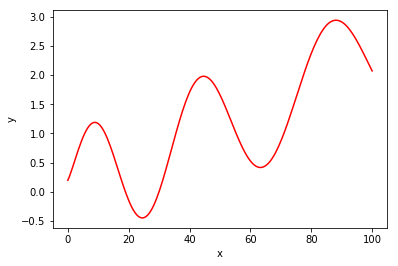

In [30]:
xs = np.linspace(0,100,200)
y = [black_box1D(x) for x in xs]
plt.plot(xs, y, 'r')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

#### Tabu Search itself

In [39]:
from random import randint
from collections import deque

def tweak_1D(solution):
    return solution + np.random.normal(0,10)

def copy_1D(solution):
    r = solution
    return r

def assess_quality_1D(solution):
    return black_box1D(solution)

def tabu_search_1D(solution):
    visited = [int(solution)] # for plotting
    best = (copy_1D(solution))
    # you should make sure that your list contains a range of values
    # that should not be visited again
    tabu_list = deque(visited, 10) # use as FIFO, max_len = 10
    n = 5 # numbers of tweaks desired to sample the gradient
    time_amount = 1000
    while(time_amount != 0):
        R = tweak_1D(copy_1D(solution))
        # n tweaks from current solution
        for i in range(n):
            W = tweak_1D(copy_1D(solution))
            # only take W if better and not visited yet or if R was visited
            if((W not in tabu_list) and (assess_quality_1D(W) > assess_quality_1D(R)) or (R in tabu_list)):
                R = W
        # only take R as current solution if better and not visited yet
        if((R not in tabu_list) and (assess_quality_1D(R) > assess_quality_1D(solution))):
            solution = R
            tabu_list.append(R)
            visited.append(int(solution)) # for plotting
        if(assess_quality_1D(solution) > assess_quality_1D(best)):
            best = solution
        time_amount = time_amount - 1
    return best, visited

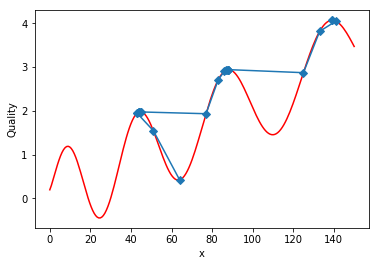

Best: 139
Visited: [64, 51, 43, 43, 45, 45, 44, 44, 44, 44, 44, 77, 83, 86, 88, 88, 87, 88, 88, 88, 88, 125, 133, 141, 139, 139]


In [42]:
init_solution = randint(0,100)
best, visited = tabu_search_1D(init_solution)

plt.plot(xs, y, 'r')
plt.plot(visited, [black_box1D(x) for x in visited], '-D')
plt.xlabel('x')
plt.ylabel('Quality')
plt.show()

print("Best:", int(best))
print("Visited:", visited)

## 3. Implementing Iterated Local Search

### Recap: Iterated Local Search

Idea:
- improved version of Hill Climbing with Random Restarts
- restart at a position where it likely finds a new local optimum
- find a local optimum, then searches for a nearby local optimum, and so on
- heuristic: find better local optimum in the neighborhood of your current local optimum (better than complete random)
- restart positions not entirely random, but random in a certain distance to a “home base” local optimum
- if a new local optimum has been found, decide whether it becomes the new “home base”

#### Iterated Local Search itself

In [43]:
from random import randint

def tweak_1D(solution):
    return solution + np.random.normal(0,2)

def copy_1D(solution):
    r = solution
    return r

def assess_quality_1D(solution):
    return black_box1D(solution)

def new_home_base_1D(home, solution):
    # very simple decision
    # you should try to make up a better one
    if(assess_quality_1D(solution) > assess_quality_1D(home)):
        return solution
    else:
        return home

def perturb_1D(home):
    return home + np.random.normal(0,18)

def it_local_search_1D(solution):
    visited = [int(solution)] # for plotting
    home = solution
    best = solution
    n = 2 # how many tweaks to make in each home base
    time_amount = 40
    while(time_amount != 0):
        # n tweaks from current home base
        for i in range(n):
            R = tweak_1D(copy_1D(solution))
            if(assess_quality_1D(R) > assess_quality_1D(solution)):
                solution = R
                visited.append(int(solution)) # for plotting
        if(assess_quality_1D(solution) > assess_quality_1D(best)):
            best = solution
        # wheter to stay in current home and tweak there
        # or to search a new home base
        home = new_home_base_1D(home, solution)
        solution = perturb_1D(home)
        time_amount = time_amount - 1
    return best, visited

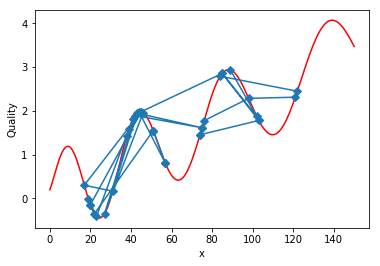

Best: 89
Visited: [20, 19, 23, 39, 41, 38, 45, 17, 31, 43, 75, 42, 27, 46, 44, 57, 57, 57, 51, 51, 51, 22, 20, 45, 85, 103, 103, 74, 75, 74, 76, 98, 121, 122, 84, 85, 102, 89]


In [62]:
init_solution = randint(0,50)
best, visited = it_local_search_1D(init_solution)

xs = np.linspace(0,150,200)
y = [black_box1D(x) for x in xs]
plt.plot(xs, y, 'r')
plt.plot(visited, [black_box1D(x) for x in visited], '-D')
plt.xlabel('x')
plt.ylabel('Quality')
plt.show()

print("Best:", int(best))
print("Visited:", visited)